In [1]:
#Import libraries as needed
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col, first, last, lag, lead, when
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number

conf = SparkConf().setAppName('yuck').setMaster("local[*]").set("spark.driver.memory", "4g")
sc = SparkContext(conf=conf)
spark = SparkSession(sc)

In [3]:
#SCALED VERSION WITH BIG DATA SET STARTS HERE

from pyspark.sql.functions import unix_timestamp
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, TimestampType

# Define the schema for the CSV files
schema = StructType ([
 StructField ('date', StringType(), True ),
 StructField ('BEN', DoubleType(), True ),
 StructField ('CO', DoubleType(), True ),
 StructField ('EBE', DoubleType(), True ),
 StructField ('MXY', DoubleType(), True ),
 StructField ('NMHC', DoubleType(), True ),
 StructField ('NO_2', DoubleType(), True ),
 StructField ('NOx', DoubleType(), True ),
 StructField ('OXY', DoubleType(), True ),
 StructField ('O_3', DoubleType(), True ),
 StructField ('PM10', DoubleType(), True ),
 StructField ('PM25', DoubleType(), True ),
 StructField ('PXY', DoubleType(), True ),
 StructField ('SO_2', DoubleType(), True ),
 StructField ('TCH', DoubleType(), True ),
 StructField ('TOL', DoubleType(), True )])

In [4]:
# insert csv files to spark_df dataframe
data_path = 'C:\\Users\\eleni\\Documents\\Diplw\\Jupyter-Notebooks\\diplw\\csvs_per_year'
spark_df = spark.read.csv(data_path, header=True, schema=schema)

In [5]:
# Convert the ’date’ column to Unix timestamps
from pyspark.sql.functions import unix_timestamp, to_utc_timestamp
from pyspark.sql.types import TimestampType
spark_df = spark_df.withColumn('unix_time', unix_timestamp(spark_df.date ,'yyyy-MM-dd HH:mm:ss').cast('timestamp')).drop('date')

In [6]:
# Order the DataFrame by unix_time and add a row number column
window = Window.orderBy('unix_time')
spark_df = spark_df.withColumn('row_num', row_number().over(window))

In [7]:
#FILL IN MISSING VALUES STARTS HERE
# Add previous and next value columns for each column except 'unix_time' and 'row_num'
for col_name in spark_df.columns:
    if col_name != "unix_time" and col_name != "row_num":
        spark_df = spark_df.withColumn(f"{col_name}_prev", lag(col_name).over(window))
        spark_df = spark_df.withColumn(f"{col_name}_next", lead(col_name).over(window))

In [8]:
# Interpolate missing values for each column except 'unix_time' and 'row_num'
for col_name in spark_df.columns:
    if col_name != "unix_time" and col_name != "row_num":
        spark_df = spark_df.withColumn(col_name, when(col(col_name).isNull(),
                                          (last(col_name, True).over(window) +
                                           first(col_name, True).over(window)) / 2)
                                          .otherwise(col(col_name)))

In [9]:
# Drop the columns with previous and next value for each column
for col_name in spark_df.columns:
    if col_name.endswith("_prev") or col_name.endswith("_next"):
        spark_df = spark_df.drop(col_name)
#END FILL IN MISSING VALUES

In [16]:
#Outlier Handling and normalization in apache spark

from pyspark.ml.feature import RobustScaler
# Get the columns to normalize
pollutants = spark_df.columns[:-2]
outliers = {}


In [17]:
for pollutant in pollutants:
    # Find outliers using the IQR method with k=1.5
    quantiles = spark_df.approxQuantile(pollutant, [0.25, 0.75], 0.05)
    Q1 = quantiles[0]
    Q3 = quantiles[1]
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers[pollutant] = (lower_bound, upper_bound)

In [18]:
spark_df_clean = spark_df.select(spark_df.columns)

In [23]:
# Replace outliers with null values
from pyspark.sql.functions import col
for pollutant in pollutants:
    # Rename the original column
    spark_df_clean = spark_df_clean.withColumnRenamed(pollutant, f"{pollutant}_orig")

    # Replace outliers with null values
    expr = when(~col(f"{pollutant}_orig").between(outliers[pollutant][0], outliers[pollutant][1]), None).otherwise(col(f"{pollutant}_orig")).alias(pollutant)
    spark_df_clean = spark_df_clean.select("*", expr)
    spark_df_clean = spark_df_clean.drop(f"{pollutant}_orig")
    spark_df_clean = spark_df_clean.fillna({f"{pollutant}": "null"})

In [25]:
#Interpolate->Fill null values of 'spark_df_clean'
# Order the DataFrame by unix_time and add a row number column
window_clean = Window.orderBy('unix_time')
spark_df_clean = spark_df_clean.withColumn('row_num', row_number().over(window_clean))

In [26]:
# Add previous and next value columns for each column except 'unix_time' and 'row_num'
for col_name in spark_df_clean.columns:
    if col_name != "unix_time" and col_name != "row_num":
        spark_df_clean = spark_df_clean.withColumn(f"{col_name}_prev", lag(col_name).over(window_clean))
        spark_df_clean = spark_df_clean.withColumn(f"{col_name}_next", lead(col_name).over(window_clean))

In [27]:
# Interpolate missing values for each column except 'unix_time' and 'row_num'
for col_name in spark_df_clean.columns:
    if col_name != "unix_time" and col_name != "row_num":
        spark_df_clean = spark_df_clean.withColumn(col_name, when(col(col_name).isNull(),(last(col_name, True).over(window_clean) + first(col_name, True).over(window_clean)) / 2).otherwise(col(col_name)))

In [28]:
# Drop the columns with previous and next value for each column
for col_name in spark_df_clean.columns:
    if col_name.endswith("_prev") or col_name.endswith("_next"):
        spark_df_clean = spark_df_clean.drop(col_name)


In [31]:
#Check if interpolation successful
from pyspark.sql.functions import col, sum
from pyspark.sql.functions import isnan, when, count

null_counts = spark_df_clean.agg(*[sum(col(c).isNull().cast("int")).alias(c) for c in spark_df_clean.columns])

# Print out the null counts for each column
null_counts.show()

#END FILL IN MISSING VALUES

+---------+-------+---+---+---+---+----+----+---+---+---+----+----+---+----+---+---+
|unix_time|row_num|BEN| CO|EBE|MXY|NMHC|NO_2|NOx|OXY|O_3|PM10|PM25|PXY|SO_2|TCH|TOL|
+---------+-------+---+---+---+---+----+----+---+---+---+----+----+---+----+---+---+
|        0|      0|  0|  0|  0|  0|   0|   0|  0|  0|  0|   0|   0|  0|   0|  0|  0|
+---------+-------+---+---+---+---+----+----+---+---+---+----+----+---+----+---+---+



In [30]:
#PXY has 100 null values after interpolation, i will fill those seperately
from pyspark.sql.functions import mean

# Calculate the mean value of the 'PXY' column
mean_val = spark_df_clean.select(mean(spark_df_clean['PXY'])).collect()[0][0]

# Fill the remaining null values in the 'PXY' column with the mean value
spark_df_clean = spark_df_clean.fillna(mean_val, subset=['PXY'])

In [23]:
#IF I WANT SCALING IT CAN BE DONE AS SUCH:
#from pyspark.sql.functions import expr, col, round
# Calculate the quartiles and IQR for each column
#quartiles = spark_df_clean.approxQuantile(pollutants, [0.25, 0.75], 0.01)
# Calculate the IQR-normalized values for each column
#spark_df_norm = spark_df_clean
#for i, col_name in enumerate(pollutants):
#    q1 = quartiles[i][0]
#    q3 = quartiles[i][1]
#    iqr = q3 - q1
#    spark_df_norm= spark_df_norm.withColumn(col_name, (col(col_name) - q1) / iqr)

In [ ]:
#Leave this area for debugging, printing rows,values,columns etc.

In [32]:
#sample spark_df to visualize data

sampled_data = spark_df_clean.select('SO_2', 'NO_2', 'PM25', 'PM10', 'O_3').sample(False, 0.3) #30% of the data
pandas_df = sampled_data.toPandas()

In [62]:
sampled_SO2 = spark_df_clean.select('SO_2').sample(False, 0.7) #50% of the SO2 column
pandas_df_SO2 = sampled_SO2.toPandas()

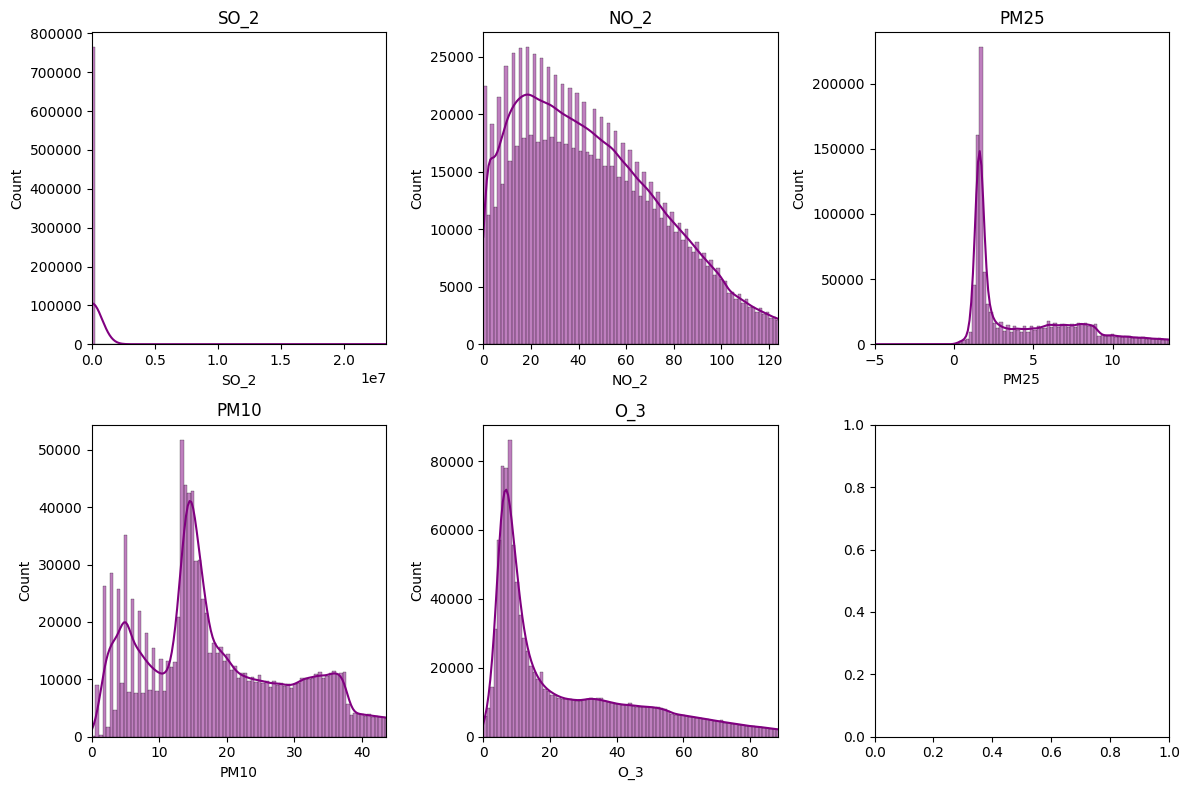

In [33]:
#histograms for only selected pollutants
pandas_df = pandas_df.reset_index(drop=True)

# Create a 2x3 grid of subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))

# Loop through the pollutants and plot the histograms in each subplot
for i, pollutant in enumerate(pandas_df.columns):
    row = i // 3
    col = i % 3
    ax = axes[row, col]
    sns.histplot(data=pandas_df, x=pollutant, kde=True, color="purple",bins=100, ax=ax)
    ax.set_title(pollutant)
    # get the range of values in the column, ignoring NaN and Inf
    x_min = np.nanmin(pandas_df[pollutant][np.isfinite(pandas_df[pollutant])])
    x_max = np.nanmax(pandas_df[pollutant][np.isfinite(pandas_df[pollutant])])

    # set the x-axis limits
    ax.set_xlim(x_min, x_max/1.2)
    
plt.tight_layout()
plt.show()


In [ ]:
pandas_df.tail(10)

In [ ]:
#Pathainei ligo kokobloko opote tha prospathisw na kanw histogram gia kathe column ksexwrista gamwt
sns.histplot(data=pandas_df_SO2, x='SO_2', kde=True, color='purple',bins=100)
# set the x-axis and y-axis limits
plt.xlim(0, 3)
plt.ylim(0, 200000)

# show the plot
plt.show()

In [ ]:
print(spark_df.columns)


In [47]:
print(spark_df_clean.columns)

['unix_time', 'row_num', 'BEN', 'CO', 'EBE', 'MXY', 'NMHC', 'NO_2', 'NOx', 'OXY', 'O_3', 'PM10', 'PM25', 'PXY', 'SO_2', 'TCH', 'TOL']


In [26]:
print(pollutants)

['BEN', 'CO', 'EBE', 'MXY', 'NMHC', 'NO_2', 'NOx', 'OXY', 'O_3', 'PM10', 'PM25', 'PXY', 'SO_2', 'TCH', 'TOL']


In [ ]:
from pyspark.sql.functions import isnan, col

# Count the number of null values in the 'TOL' column of 'spark_df'
tol_null_count = spark_df.filter(isnan(col('TOL'))).count()

print(f"The 'TOL' column of 'spark_df' has {tol_null_count} null values.")


In [ ]:
from pyspark.sql.functions import col, sum

null_counts = spark_df.agg(*[sum(col(c).isNull().cast("int")).alias(c) for c in spark_df.columns])

# Print out the null counts for each column
null_counts.show()


In [ ]:
spark_df.show(10)


In [ ]:
spark_df_clean.show(10)

In [18]:
total_rows = spark_df.select("unix_time").count()
print("Total number of rows in unix_time column: ", total_rows)

Total number of rows in unix_time column:  3808224


In [34]:
# Write the merged DataFrame to a CSV file
spark_df_clean.write.format('csv').option('header', True ).mode('overwrite').save('C:\\Users\\eleni\\Documents\\Diplw\\Jupyter-Notebooks\\diplw\\csvs_per_year\\yuck')